In [1]:
from matplotlib import pyplot
import numpy as np
from open_atmos_jupyter_utils import show_plot
from PySDM.environments import ExpansionChamber
from PySDM import products
from PySDM import Builder, Formulae
from PySDM.physics.constants import si, in_unit, PER_CENT
from PySDM.dynamics import AmbientThermodynamics
from PySDM.backends import CPU
from PySDM_examples.utils import BasicSimulation

In [7]:
class Simulation(BasicSimulation):
    def __init__(self):
        builder = Builder(n_sd=0, backend=CPU(), environment=ExpansionChamber(
            dt = .1 * si.s,
            volume=.14 * si.m**3,
            initial_pressure=1 * si.bar,
            initial_temperature=293.15 * si.K,
            initial_relative_humidity=.7,
            delta_time=1 * si.s,
            delta_pressure=-.54 * si.bar,
            delta_temperature=-35 * si.K,
        ))
        builder.add_dynamic(AmbientThermodynamics())
        super().__init__(builder.build(
            attributes={
                "multiplicity": np.array([1]),
                "water mass": np.array([1 * si.ug]),
            },
            products=(
                products.AmbientPressure(var='p'),
                products.AmbientTemperature(var='T'),
                products.AmbientRelativeHumidity(var='RH'),
                products.Time(),
            )
        ))

    def run(self):
        return self._run(nt=int(30 * si.s / self.particulator.environment.dt), steps_per_output_interval=1)

In [8]:
simulation = Simulation()
output = simulation.run()

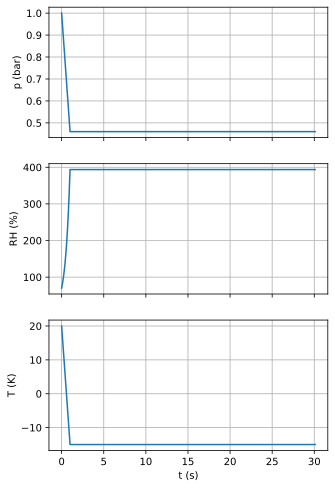

In [9]:
fig, axs = pyplot.subplot_mosaic([['p'], ['RH'], ['T']], sharex=True, figsize=(5, 8))

axs["p"].plot(output['time'], in_unit(np.asarray(output['ambient pressure']), si.bar))
axs["p"].set_ylabel('p (bar)')

axs["RH"].plot(output['time'], in_unit(np.asarray(output['ambient relative humidity']), PER_CENT))
axs["RH"].set_ylabel('RH (%)')

axs["T"].plot(output['time'], np.asarray(output['ambient temperature']) - Formulae().constants.T0)
axs["T"].set_ylabel('T (K)')
axs["T"].set_xlabel('t (s)')
for ax in axs.values(): ax.grid()
show_plot(filename='fig_3')